In [1]:
from tqdm import tqdm
import treescope as ts
import matplotlib.pyplot as plt
import torch


class Logger(dict):
    def log(self, vals={}, *, pbar=None, prefix="", suffix="", **kwargs):
        vals = {**vals, **kwargs}
        for k, v in vals.items():
            self.setdefault(k, []).append(v)
        if pbar is not None:
            vals = {prefix + k + suffix: f"{v:.6f}" for k, v in vals.items()}
            pbar.set_postfix(**vals)

In [2]:
from data import DNADataset
dataset = DNADataset("hf://datasets/Zehui127127/latent-dna-diffusion/sequence.csv")

Loading data from hf://datasets/Zehui127127/latent-dna-diffusion/sequence.csv...
Processing data...
Done!


In [3]:
from vqvae import SequenceCVQVAE
model = SequenceCVQVAE(in_dim=5, c_dim=15, dim=32, fsq_maxlevel=2)
ts.display(model)

In [4]:
device = torch.device("cuda:0")
model = model.to(device=device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

logger = Logger()
epochs = 100
for j in range(epochs):
    for i, (X, y) in enumerate(pbar := tqdm(dataloader, desc=f"Epoch {j}")):
        

        X = X.to(device=device, non_blocking=True)
        y = y.to(device=device, non_blocking=True)
        loss_recon = model.losses(X, y)
        
        optimizer.zero_grad()
        loss_recon.backward()
        optimizer.step()

        logger.log(recon=loss_recon.item(), pbar=pbar)

    if (j+1) % 10 == 0:
        torch.save(model, f"model_epoch_{j+1}.pth")

Epoch 66:  31%|███       | 191/622 [00:41<01:33,  4.60it/s, recon=1.177628]


KeyboardInterrupt: 

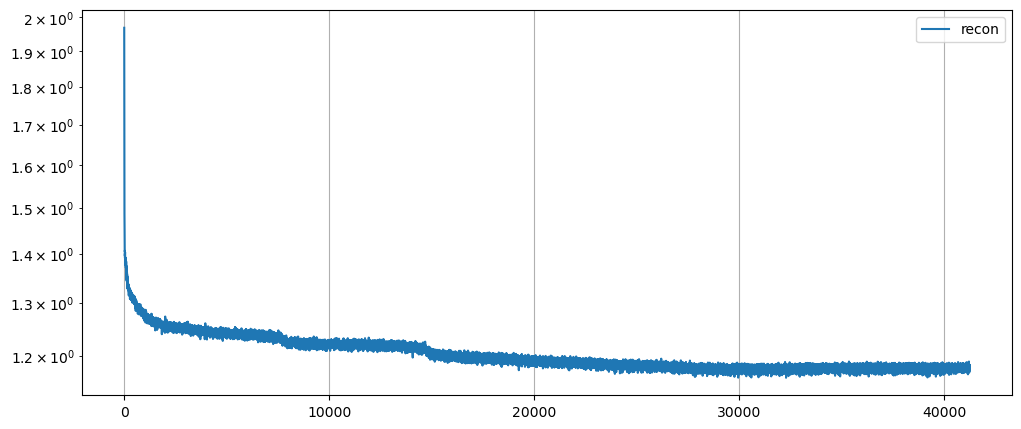

In [5]:
plt.figure(figsize=(12, 5))
plt.semilogy(logger["recon"], label="recon")
plt.legend()
plt.grid()
plt.show()